In [2]:
## Import statements
import xarray
import numpy as np
import pyart
import metpy.calc as metcalc
from metpy.units import units
import proplot as pplt
import imageio

import math
import matplotlib.pyplot as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from PIL import Image

import os, glob
import wildfire2 as wf2

import datetime
from netCDF4 import Dataset as ncDataset
import cartopy.crs as ccrs
import pyproj
import rasterio.crs
from rasterio import Affine
from rasterio.warp import reproject, Resampling
from rasterio.mask import mask
import numpy.ma as ma

import shapely
from shapely import geometry
from matplotlib import cm
import fiona

import satpy.modifiers.parallax as smp

from cartopy_map_utils import proj4_to_cartopy
import model as md
import echotop as et


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/196/jv1871/echotop.py:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def cloud_top_height(
/home/196/jv1871/echotop.py:132: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def column_max_reflectivity(r, azimuth, elevation, st_sweep, ed_sweep, refl):


In [2]:
import matplotlib.pyplot as plt

In [3]:
## Gets lightning data from date/time and coordinates.
def getLightningData(year, month, day, time, minLat, maxLat, minLon, maxLon):
    import atmscitools as ast
    import netCDF4 as nc
            
        
    # Get zip filename      
    path_ltng = f'/g/data/rq0/admin/aura_rainfields/unpublished/310/{year}/ltng-dens/'
    filename_zip = path_ltng + f'310_{year}{month}{day}.ltng-dens.zip'
        
    # File to scan
        
    scan = f'310_{year}{month}{day}_{time}00.ltng-dens.nc'
        
    # Extract the file and convert it to xarray
    
    nc_ds = nc.Dataset('diskless', diskless=True,
                        memory = ast.extract_item_from_zip_to_memory(filename_zip, scan))
    ds = xarray.open_dataset(xarray.backends.NetCDF4DataStore(nc_ds))
    
    x = ds.x
    y = ds.y
            
    proj = ds.proj
    ltng = ds.lightning_density
            
    proj4string_ltng = md.convert_proj_to_proj4string(proj)
    lat_2d, lon_2d = md.calc_lat_lon_from_proj(proj4string_ltng, 1000*y, 1000*x)
            
    # Create xarray DataArray for masked array
        
    data_var = xarray.DataArray(ltng.data, dims=('y', 'x'), 
                                coords={'latitude': (('y', 'x'), lat_2d),
                                        'longitude': (('y', 'x'), lon_2d)})
    
    # Create xarray DataArray for longitude and latitude
        
    lon_var = xarray.DataArray(lon_2d, dims=('y', 'x'), 
                                coords={'latitude': (('y', 'x'), lat_2d),
                                        'longitude': (('y', 'x'), lon_2d)})
    
    lat_var = xarray.DataArray(lat_2d, dims=('y', 'x'), 
                                coords={'latitude': (('y', 'x'), lat_2d),
                                        'longitude': (('y', 'x'), lon_2d)})
            
    # Create xarray Dataset with all three data variables
        
    ltng_latlon = xarray.Dataset({'lightning_density': data_var, 'longitude': lon_var, 'latitude': lat_var})
    ltng_latlon.attrs['proj'] = proj4string_ltng

    c1 = ltng_latlon['latitude'] < maxLat
    c2 = ltng_latlon['latitude'] > minLat
    c3 = ltng_latlon['longitude'] < maxLon
    c4 = ltng_latlon['longitude'] > minLon
    lightning_ds = ltng_latlon.where(c1 & c2 & c3 & c4, drop = True)

    return lightning_ds

In [4]:
## This method will update the radar object to include maximum reflectivity and echotop cloud height.
def updateRadarData(radar):
    ## Gets variables needed for methods below.
    range = ma.getdata(radar.range['data'])
    azimuth = ma.getdata(radar.azimuth['data'])
    elevation = ma.getdata(radar.elevation['data'])
    corrected_reflectivity = ma.getdata(radar.fields['corrected_reflectivity']['data'])
    start_index = ma.getdata(radar.sweep_start_ray_index['data'])
    end_index = ma.getdata(radar.sweep_end_ray_index['data'])

    ## Calls echotop_cloud_height function and column_max_reflectivity function.
    cloudtop = et.cloud_top_height(range, azimuth, elevation, start_index, end_index, corrected_reflectivity)
    max_reflectivity = et.column_max_reflectivity(range, azimuth, elevation, start_index, end_index, corrected_reflectivity)
    max_reflectivity = np.where(max_reflectivity < 0, np.nan, max_reflectivity)

    ## Resizes the data by just repeating it (In this case, the data presenetd only enough to fill the firsts weep. The data is repeated to fill the remaining sweeps).
    ## Data is also excluded if they are negligble. 
    cloudtop_final = np.resize(cloudtop, (corrected_reflectivity.shape[0], corrected_reflectivity.shape[1]))
    max_reflectivity_final = np.resize(max_reflectivity, (corrected_reflectivity.shape[0], corrected_reflectivity.shape[1]))

    ## Adds the dataset to the fields in question
    radar.add_field('echotop_cloud_height', {'data' : cloudtop_final})
    radar.add_field('maximum_reflectivity', {'data' : max_reflectivity_final})

    return radar

In [5]:
## Trying to read in radar
radar = pyart.io.read('data/Radar/20191228_40/40_20191228_060029_ppi.nc')

range = ma.getdata(radar.range['data'])
azimuth = ma.getdata(radar.azimuth['data'])
elevation = ma.getdata(radar.elevation['data'])
corrected_reflectivity = ma.getdata(radar.fields['corrected_reflectivity']['data'])
start_index = ma.getdata(radar.sweep_start_ray_index['data'])
end_index = ma.getdata(radar.sweep_end_ray_index['data'])

In [4]:
cloudtop = et.cloud_top_height(range, azimuth, elevation, start_index, end_index, corrected_reflectivity)
max_reflectivity = et.column_max_reflectivity(range, azimuth, elevation, start_index, end_index, corrected_reflectivity)
max_reflectivity = np.where(max_reflectivity < 0, np.nan, max_reflectivity)

In [5]:
cloudtop_final = np.resize(cloudtop, (corrected_reflectivity.shape[0], corrected_reflectivity.shape[1]))
max_reflectivity_final = np.resize(max_reflectivity, (corrected_reflectivity.shape[0], corrected_reflectivity.shape[1]))

In [6]:
radar.add_field('echotop_cloud_height', {'data' : cloudtop_final})

In [7]:
radar.add_field('maximum_reflectivity', {'data' : max_reflectivity_final})

In [8]:
lat, lon, alt = radar.get_gate_lat_lon_alt(sweep=0)

In [21]:
grid = pyart.map.grid_from_radars(radar, grid_shape=(41, 400, 400), grid_limits = ((0, 20000), (-200000, 200000), (-200000, 200000)))

/home/196/jv1871/miniforge3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/196/jv1871/miniforge3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/196/jv1871/miniforge3/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8242 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/196/jv1871/miniforge3/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8242 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/196/jv1871/miniforge3/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:240: Run

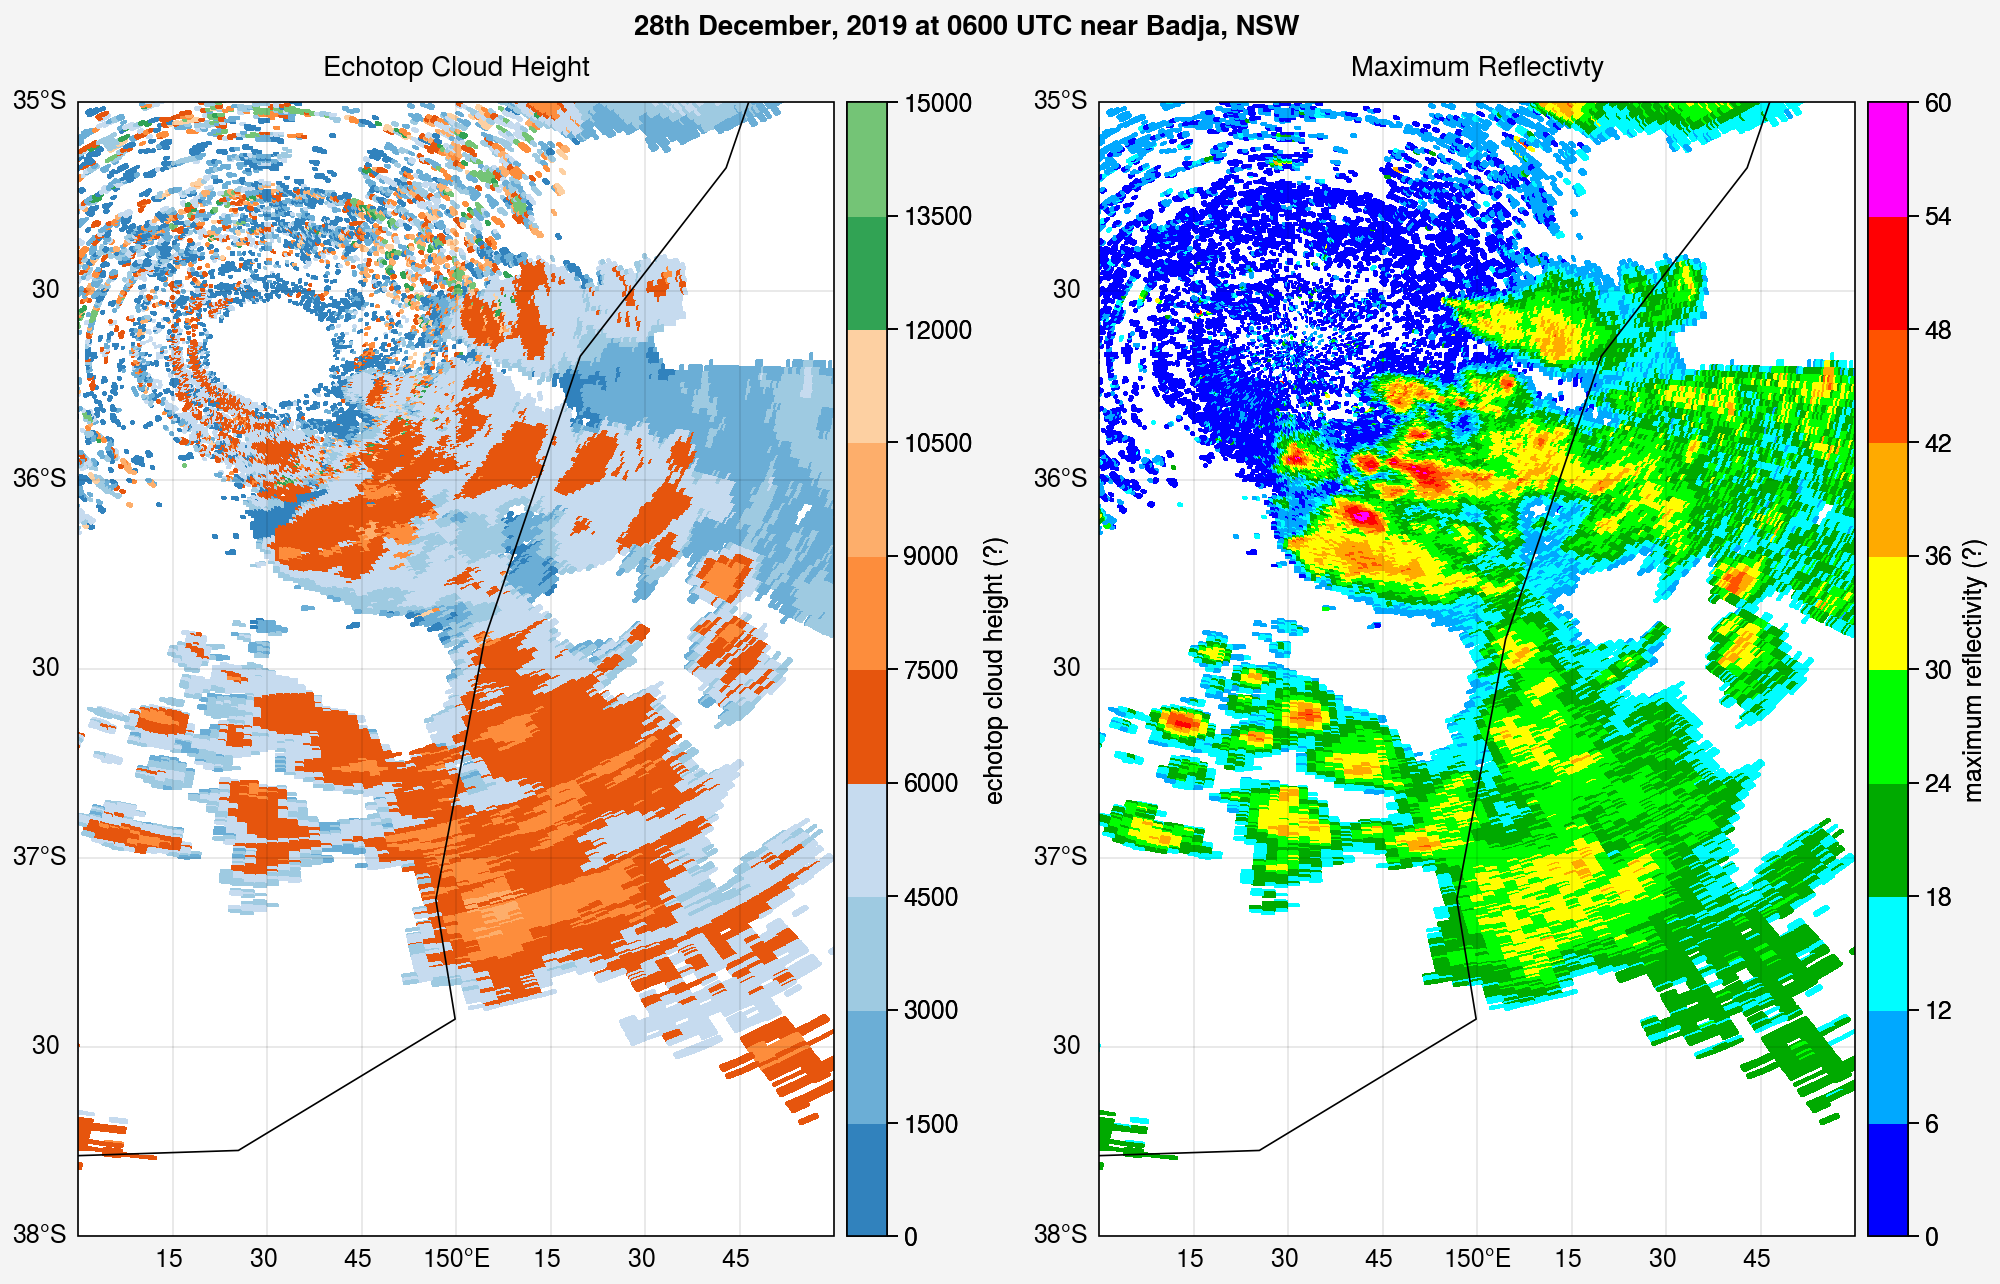

In [23]:
display = pyart.graph.RadarMapDisplay(radar, shift=(0,0))
fig, axs = pplt.subplots(ncols=2, nrows=1, width=10, suptitle="10th December, 2019 at 0600 UTC near Cockatoo Hill, NSW", sharex = False, sharey = False, projection=ccrs.PlateCarree())
axs[0].set_extent([149,151,-38,-35])
display.plot_ppi_map('echotop_cloud_height', cmap='tab20c', vmin=0, vmax=15000, sweep=0, ax=axs[0], min_lat=-38, max_lat=-35, min_lon=149, max_lon=151, title="Echotop Cloud Height")
axs[0].format(labels=True)
axs[1].set_extent([149, 151, -38, -35])
display.plot_ppi_map('maximum_reflectivity', ax=axs[1], sweep=0, cmap="pyart_refdiff", vmin=0, vmax=60, title='Maximum Reflectivty', min_lat=-38, max_lat=-35, min_lon=149, max_lon=151)
axs[1].format(labels=True)

In [26]:
lightning_ds = getLightningData(2019, 12, 28, '0600', -38, -35, 149, 151)
ltng = np.where(lightning_ds.lightning_density > 0, lightning_ds.lightning_density, np.nan)

In [29]:
np.nanmin(ltng)

1.0

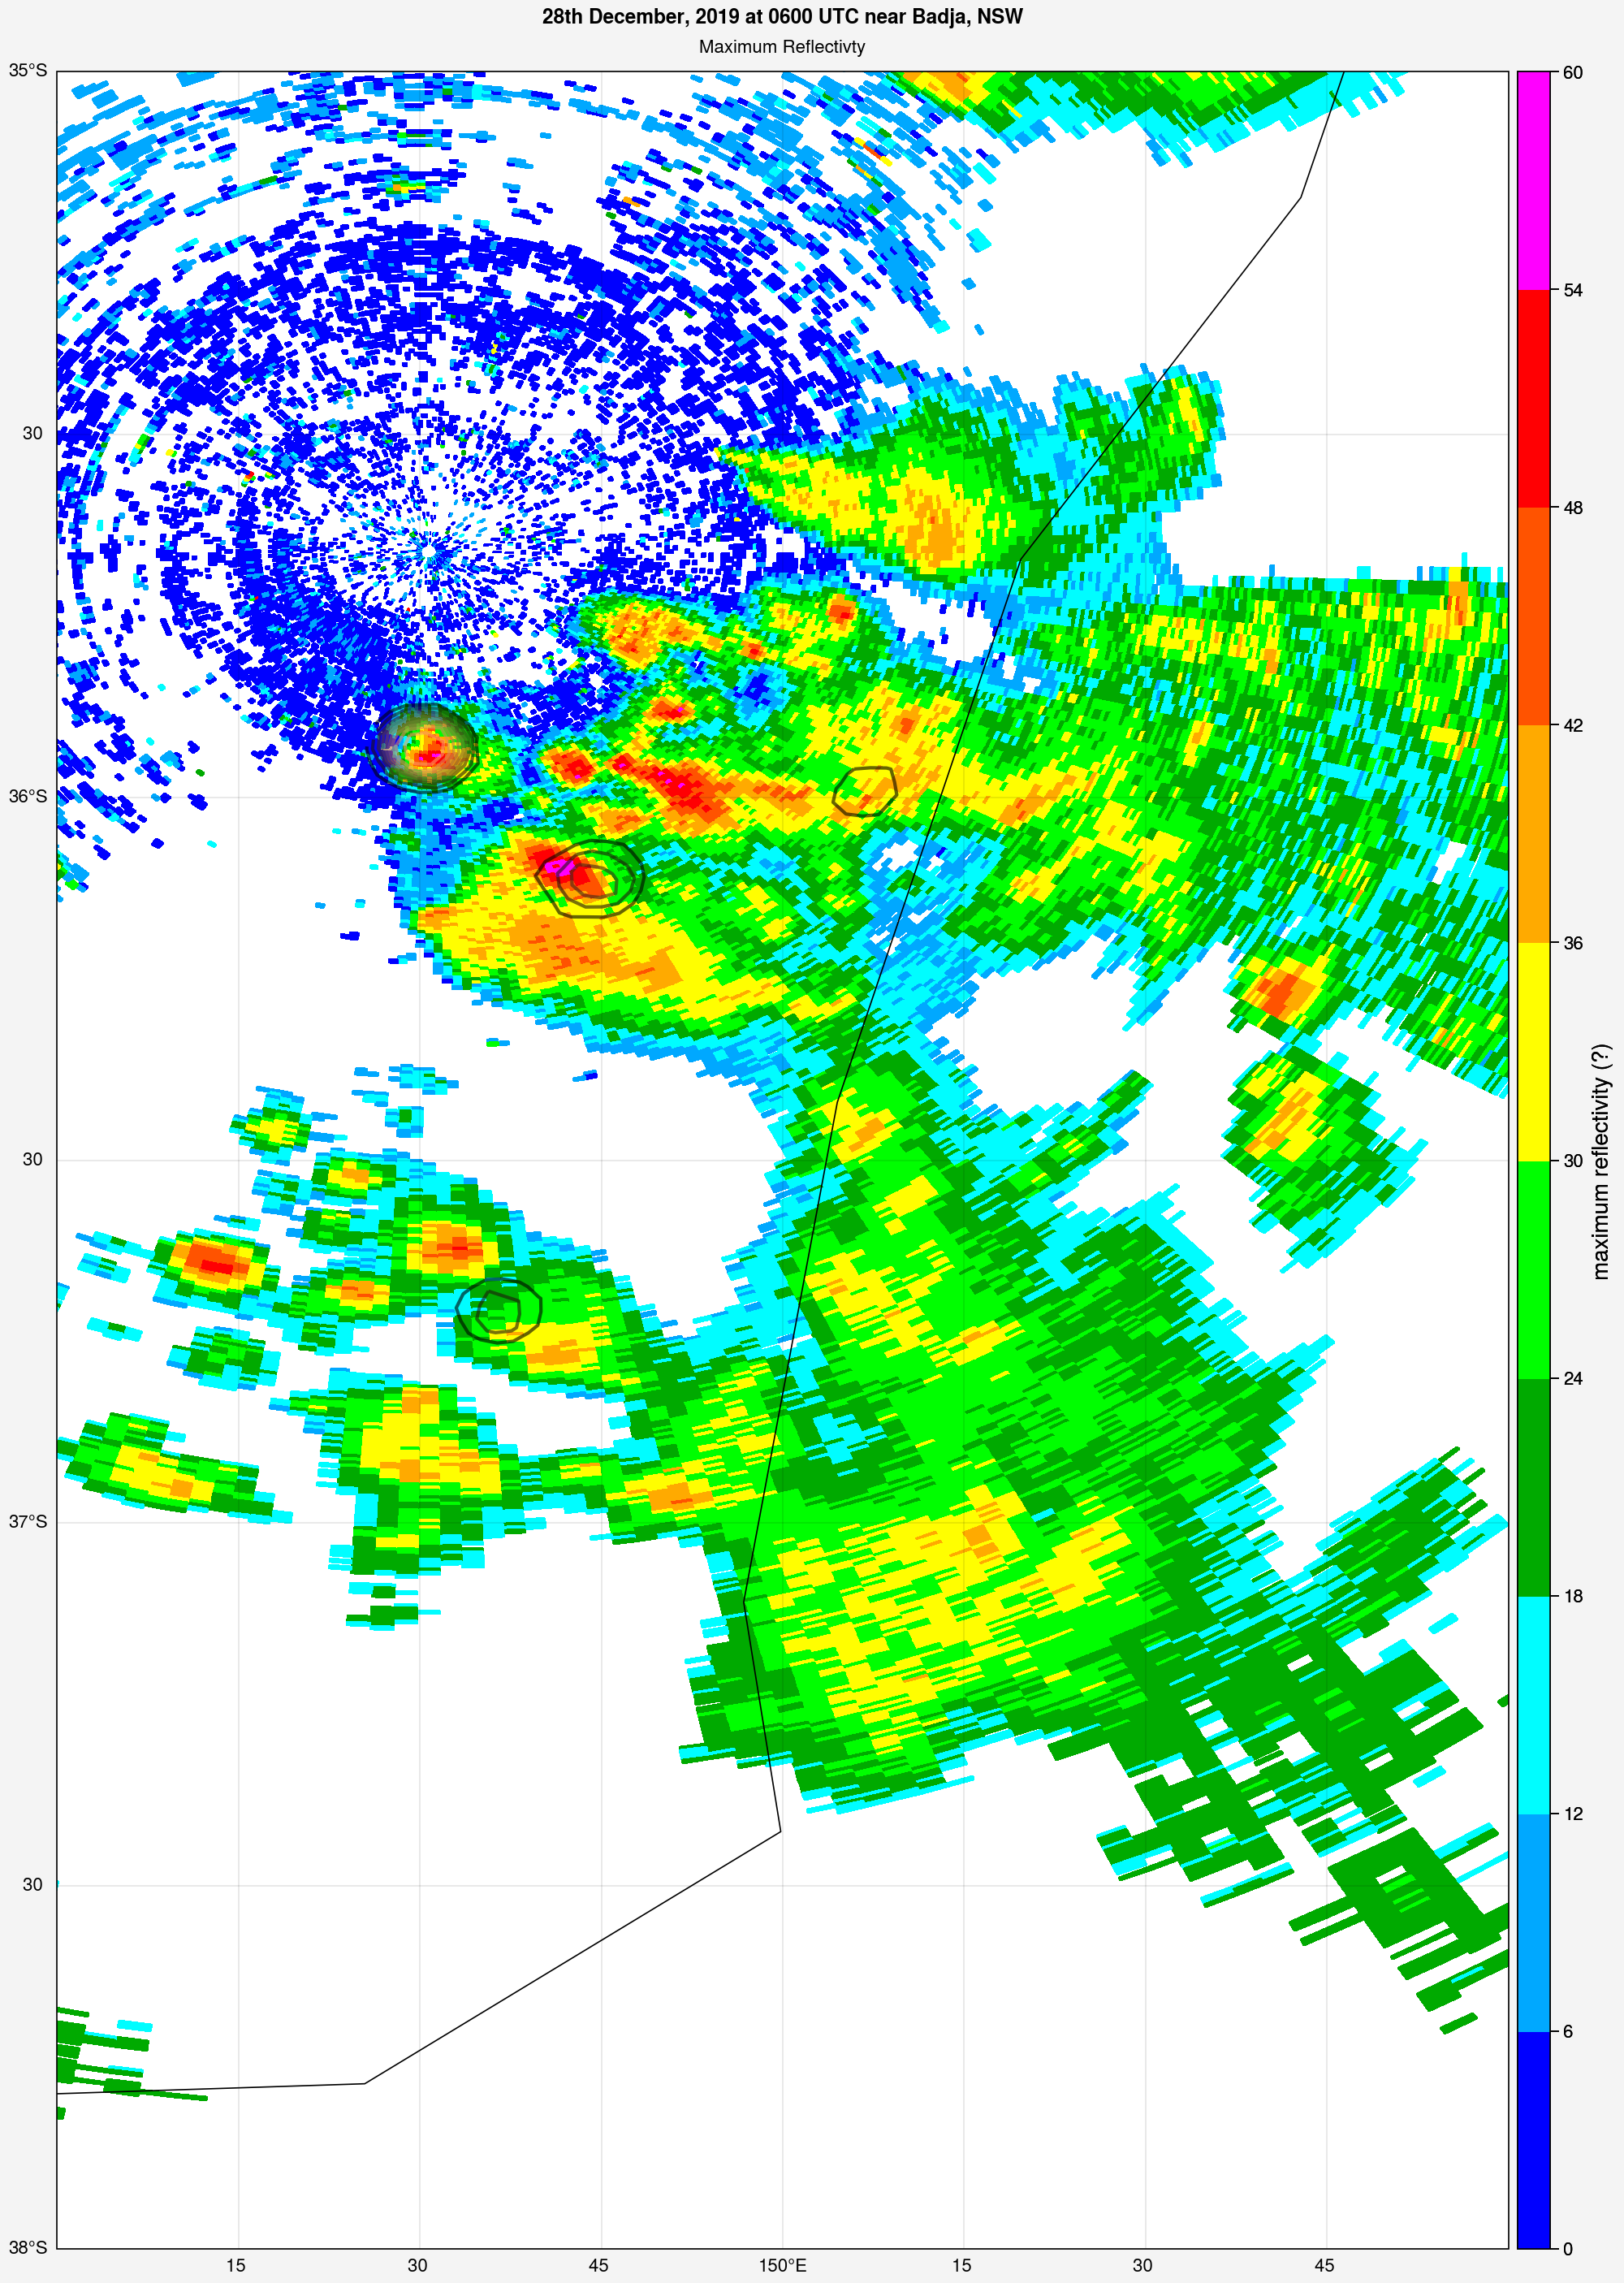

In [31]:
fig, axs = pplt.subplots(ncols=1, nrows=1, width=10, suptitle="28th December, 2019 at 0600 UTC near Badja, NSW", sharex = False, sharey = False, projection=ccrs.PlateCarree())
axs[0].set_extent([149, 151, -38, -35])
display.plot_ppi_map('maximum_reflectivity', ax=axs[0], sweep=0, cmap="pyart_refdiff", vmin=0, vmax=60, title='Maximum Reflectivty', min_lat=-38, max_lat=-35, min_lon=149, max_lon=151)
axs[0].format(labels=True)
axs[0].contour(lightning_ds.longitude, lightning_ds.latitude, ltng, vmax = 1.1*np.nanmax(ltng), ymin=-38, ymax= -35,
                     cmap = 'copper', alpha = 0.6, transform=ccrs.PlateCarree())

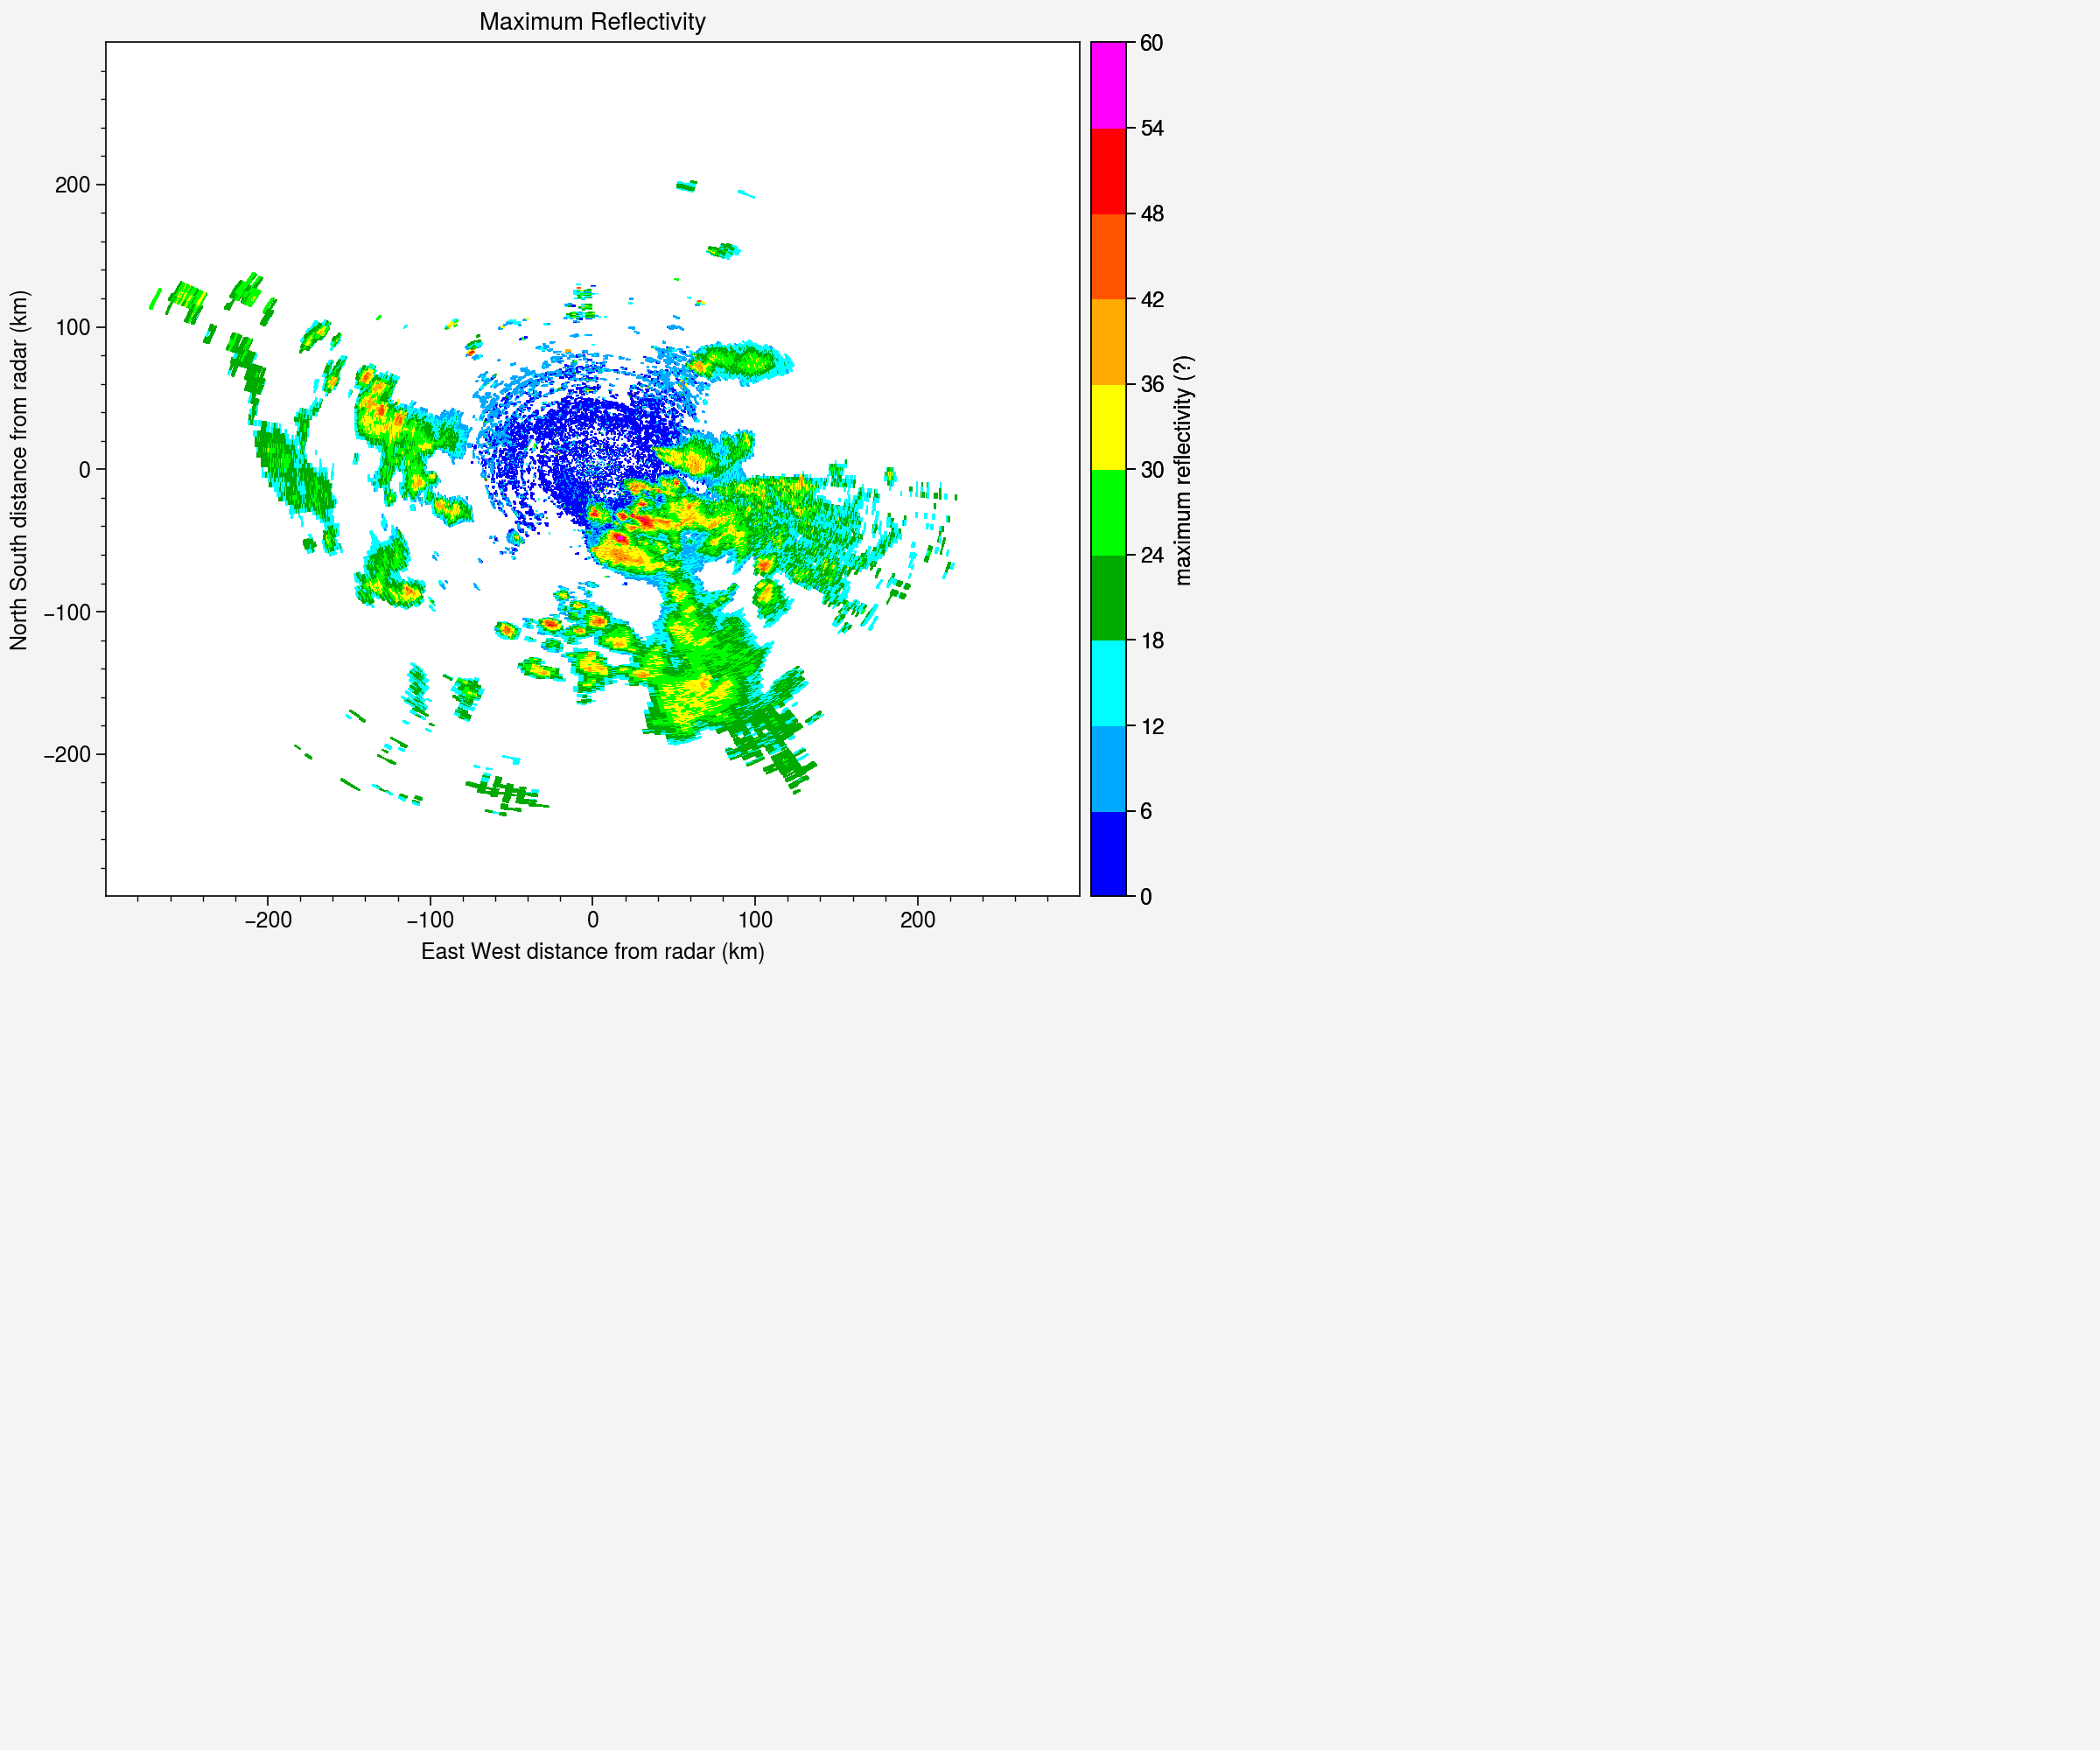

In [59]:
fig = pplt.figure(figsize=(12,10))
display = pyart.graph.RadarDisplay(radar)
ax1 = plt.subplot(221)
display.plot_ppi("maximum_reflectivity", sweep=0, cmap='pyart_refdiff', vmin=0, vmax=60, title="Maximum Reflectivity")

In [36]:
radar_times = ['020028', '020628', '021228', '021828', '022428', '023030', '023630', '024230', '024828', '025428',
               '030030', '030628', '031230', '031828', '032428', '033031', '033630', '034228', '034831', '035431',
               '040028', '040630', '041228', '041831', '042428', '043031', '043628', '044228', '044830', '045430',
               '050028', '050630', '051228', '051830', '052431', '053028', '053628', '054228', '054828', '055430',
               '060028', '060629', '061230', '061831', '062428', '063031', '063630', '064228', '064828', '065428',
               '070031', '070630', '071228', '071831', '072430', '073030']

In [1]:
## Loop for every time presnted within the above array.
for i in radar_times:
    ## Read in radar time from that time.
    radar = pyart.io.read('data/Radar/20191210_71/71_20191210_{time}_ppi.nc'.format(time=i))

    ## Call all variables needed to perform the column_max_reflectivity and echotop_cloud_height
    range = ma.getdata(radar.range['data'])
    azimuth = ma.getdata(radar.azimuth['data'])
    elevation = ma.getdata(radar.elevation['data'])
    corrected_reflectivity = ma.getdata(radar.fields['corrected_reflectivity']['data'])
    start_index = ma.getdata(radar.sweep_start_ray_index['data'])
    end_index = ma.getdata(radar.sweep_end_ray_index['data'])

    ## Calls echotop_cloud_height function and column_max_reflectivity function
    cloudtop = et.cloud_top_height(range, azimuth, elevation, start_index, end_index, corrected_reflectivity)
    max_reflectivity = et.column_max_reflectivity(range, azimuth, elevation, start_index, end_index, corrected_reflectivity)
    max_reflectivity = np.where(max_reflectivity < 0, np.nan, max_reflectivity)

    ## Resizes the data by just repeating it, filling the first sweep data for all remaing sweeps.
    cloudtop_final = np.resize(cloudtop, (corrected_reflectivity.shape[0], corrected_reflectivity.shape[1]))
    max_reflectivity_final = np.resize(max_reflectivity, (corrected_reflectivity.shape[0], corrected_reflectivity.shape[1]))

    ## Actually updates the radar object.
    radar.add_field('echotop_cloud_height', {'data' : cloudtop_final})
    radar.add_field('maximum_reflectivity', {'data' : max_reflectivity_final})

    ## Creates graphs of the above data.
    display = pyart.graph.RadarDisplay(radar)
    fig = pplt.figure(figtitle='Radar Data on 10 December at {time} UTC'.format(time=i))
    ax1 = fig.subplot(121)
    display.plot_ppi('echotop_cloud_height', ax=ax1, sweep=0, cmap='tab20c', vmin=0, vmax=15000, title='Echotop Cloud Height')
    ax2 = fig.subplot(122)
    display.plot_ppi('maximum_reflectivity', ax=ax2, sweep=0, cmap="pyart_refdiff", vmin=0, vmax=60, title='Maximum Reflectivty')
    fig.save('figures/20191210_71_radar/20191210_{time}_71.png'.format(time=i), dpi=300)

NameError: name 'radar_times' is not defined

In [38]:
## Make a gif with frames defined from above.
with imageio.get_writer('figures/20191210_71_radar.gif', mode='I', duration=15, loop=0) as writer:
    for i in radar_times:
        image = imageio.imread('figures/20191210_71_radar/20191210_{time}_71.png'.format(time=i))
        writer.append_data(image)

In [7]:
lcl_ds = xarray.open_dataset('data/data_lcl_nsw_black_summer.nc')

In [12]:
lcl_ds.z.values

array([[[ 613.7579 ,  629.98895,  648.62244, ..., 1398.8853 ,
         1400.233  , 1399.354  ],
        [ 615.63293,  633.21173,  652.25543, ..., 1409.8428 ,
         1411.7178 , 1412.1279 ],
        [ 614.8712 ,  634.61804,  656.00555, ..., 1417.7532 ,
         1421.2104 , 1422.8511 ],
        ...,
        [1141.8834 , 1122.8397 , 1102.331  , ..., 1354.3523 ,
         1368.1224 , 1382.8301 ],
        [1156.2394 , 1140.5942 , 1123.7186 , ..., 1339.469  ,
         1353.1218 , 1367.5951 ],
        [1163.3295 , 1152.1377 , 1140.2427 , ..., 1323.5895 ,
         1337.3596 , 1351.5984 ]],

       [[ 554.45874,  570.6898 ,  585.3388 , ..., 1388.9241 ,
         1394.432  , 1397.4204 ],
        [ 554.5759 ,  571.5687 ,  588.3272 , ..., 1396.3071 ,
         1401.8152 , 1406.327  ],
        [ 552.70087,  570.57263,  589.089  , ..., 1401.9324 ,
         1408.3193 , 1413.9445 ],
        ...,
        [1093.073  , 1077.838  , 1060.8451 , ..., 1303.7255 ,
         1318.7261 , 1333.5508 ],
        [110